In [90]:
import pandas as pd
import numpy as np
import cv2
import os
import torch
import torch.nn as nn
from torch.optim import Adam

import matplotlib.pyplot as plt


df = pd.read_csv('./words_dataset/words_new.txt', sep=' ', comment='#', header=None, on_bad_lines='skip')
df = df[df[1] != 'err']
df = df[[0, 8]]
df.columns = ['filename', 'word']

def normalize_image(image, target_size=(180, 72)):
    h, w = image.shape
    scale = min(target_size[1]/h, target_size[0]/w)
    new_h, new_w = int(h * scale), int(w * scale)
    resized = cv2.resize(image, (new_w, new_h))
    
    # Добавляем паддинг
    delta_w = target_size[0] - new_w
    delta_h = target_size[1] - new_h
    top = delta_h // 2 + 2
    bottom = delta_h - top + 2
    left = delta_w // 2
    right = delta_w - left
    
    left +=2
    right+=2
    
    padded = cv2.copyMakeBorder(resized, top, bottom, left, right, 
                               cv2.BORDER_CONSTANT, value=0)
    return padded

def load_images_and_labels(df, img_folder='./words_dataset/iam_words/words'):
    images = []
    labels = []
    
    c = 0
    k=0
    for idx, row in df.iterrows():
        c+=1
        row_splitted = row['filename'].split('-')[0:2]
        # folder = '/' + row_splitted[0] + '/' +row_splitted[0]+'-'+row_splitted[1]+'/'
        
        img_path = os.path.join(img_folder, row_splitted[0], row_splitted[0]+'-'+row_splitted[1], row['filename'] + '.png')
        if os.path.exists(img_path):
            
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            # print(f'{c} {img.size} {img_path}')
            
            img = normalize_image(img)  # Нормализация размера
            images.append(img)
            labels.append(row['word'])
        
    print(k)
    
    return images, labels

images, labels = load_images_and_labels(df)

# plt.imshow(images[0])


0


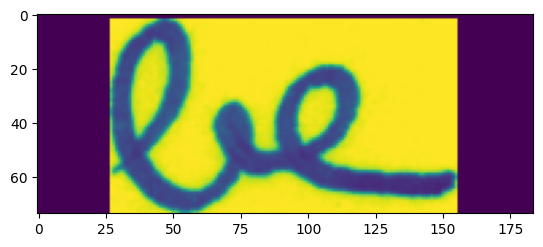

In [96]:
plt.imshow(images[15])#1235

In [92]:
shape0= []
shape1= []
length_devided_on_height = []

for image in images:
    shape0.append(image.shape[0])
    shape1.append(image.shape[1])
    length_devided_on_height.append(image.shape[1]/image.shape[0])
    if image.shape[1] == 1882:
        plt.imshow(image)
   
shapes = pd.DataFrame({'x':shape1, 'y':shape0})
proportion = pd.Series(length_devided_on_height)
print(shapes.describe())
print()
print(proportion.describe())

print(shapes['x'])

             x        y
count  27273.0  27273.0
mean     184.0     74.0
std        0.0      0.0
min      184.0     74.0
25%      184.0     74.0
50%      184.0     74.0
75%      184.0     74.0
max      184.0     74.0

count    27273.000000
mean         2.486486
std          0.000000
min          2.486486
25%          2.486486
50%          2.486486
75%          2.486486
max          2.486486
dtype: float64
0        184
1        184
2        184
3        184
4        184
        ... 
27268    184
27269    184
27270    184
27271    184
27272    184
Name: x, Length: 27273, dtype: int64
